In [1]:
# Importing necessary libraries for data cleaning and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Load the dataset
df = pd.read_csv('QF632_Project_1.csv')

In [3]:
# Examine the structure and summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1038 non-null   object 
 1   Signal     1038 non-null   float64
 2   Open       1038 non-null   float64
 3   High       1038 non-null   float64
 4   Low        1038 non-null   float64
 5   Close      1038 non-null   float64
 6   Adj Close  1038 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.9+ KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.766190   141.847360   142.691801   140.907746   141.840973   
std       3.095783    18.475574    18.470255    18.404504    18.497010   
min       0.000000    94.080002    95.400002    93.639999    94.790001   
25%      14.691150   132.132496   132.912495   130.542503   131.824993   
50%      17.298240   146.769997 

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Date         0
Signal       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64


In [5]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [6]:
# Ensure dates are in the right format and sequence
date_check = df['Date'].apply(pd.to_datetime, errors='coerce').isnull().sum()
print(f"Invalid dates: {date_check}")

# Check for date sequence issues
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
date_order_issues = (df['Date'] != df['Date'].sort_values()).any()
if date_order_issues:
    print("Dates are out of order")
else:
    print("Dates are in correct order")


Invalid dates: 0
Dates are in correct order


In [7]:
# Ensure prices and signals are non-zero and positive
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
value_check = {col: (df[col] <= 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")

Negative/zero values: {'Signal': 6, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 1}


In [8]:
# Correcting negative/zero historical prices and signal values using forward fill
for col in columns_to_check:
    # Replace zero and negative values with NaN
    df[col] = df[col].mask(df[col] <= 0)
    
    # Forward fill NaN values
    df[col].fillna(method='ffill', inplace=True)

/var/folders/n2/82c6yj0j1bv4wfsy94kcxn_80000gn/T/ipykernel_94760/4281639049.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col].fillna(method='ffill', inplace=True)


In [9]:
# Verify changes made
value_check = {col: (df[col] <= 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")

Negative/zero values: {'Signal': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 0}


In [10]:
# Examine updated data structure and summary
print("Updated Data Summary:")
print(df.info())
print(df.describe())

Updated Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
                                Date       Signal         Open         High  \
count                           1038  1038.000000  1038.000000  1038.000000   
mean   2017-12-11 17:03:48.901734144    16.881893   141.847360   142.691801   
min              2015-11-19 00:00:00    10.582996    94.080002    95.400002   
25%              2016-11-30 06:00:00    14.842406   132.132496   132

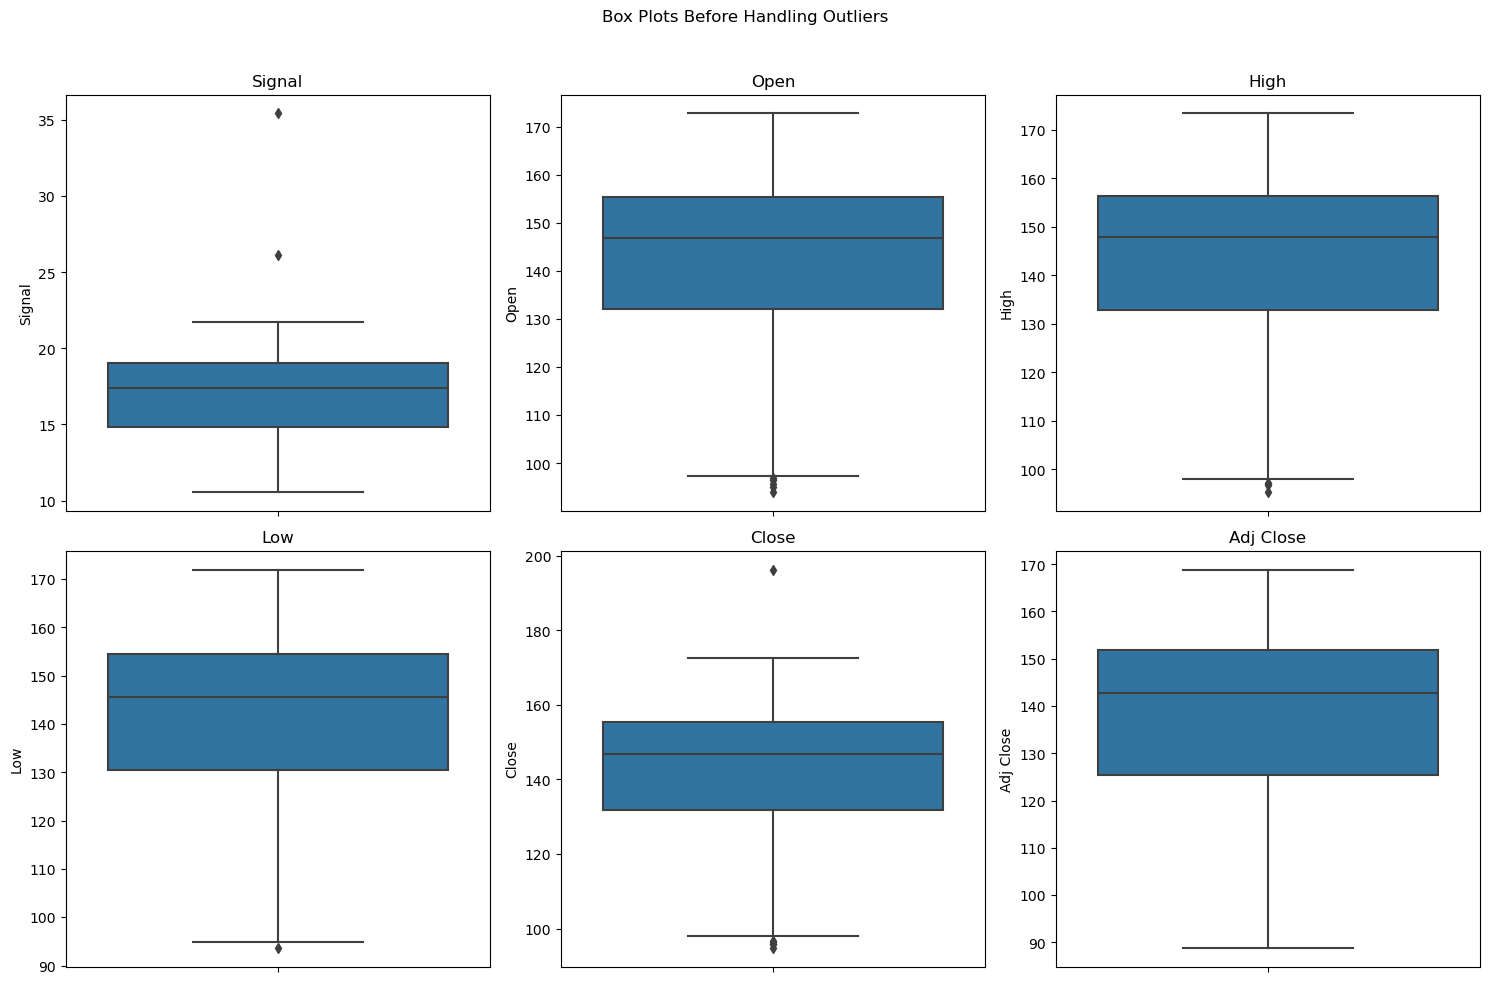

In [11]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [12]:
# Function to handle outliers using the z-score method
def handle_outliers_zscore(column):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = (df[column] - mean) / std
    outliers = abs(z_scores) > 3
    print(f"Outliers in {column}: {outliers.sum()}")
    
    # Replace outliers with NaN
    df.loc[outliers, column] = float('nan')
    
    # Forward fill NaN values
    df[column].fillna(method='ffill', inplace=True)

# Apply the z-score method to handle outliers in the specified columns
for col in columns_to_check:
    handle_outliers_zscore(col)

Outliers in Signal: 2
Outliers in Open: 0
Outliers in High: 0
Outliers in Low: 0
Outliers in Close: 0
Outliers in Adj Close: 0


/var/folders/n2/82c6yj0j1bv4wfsy94kcxn_80000gn/T/ipykernel_94760/1220883043.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)


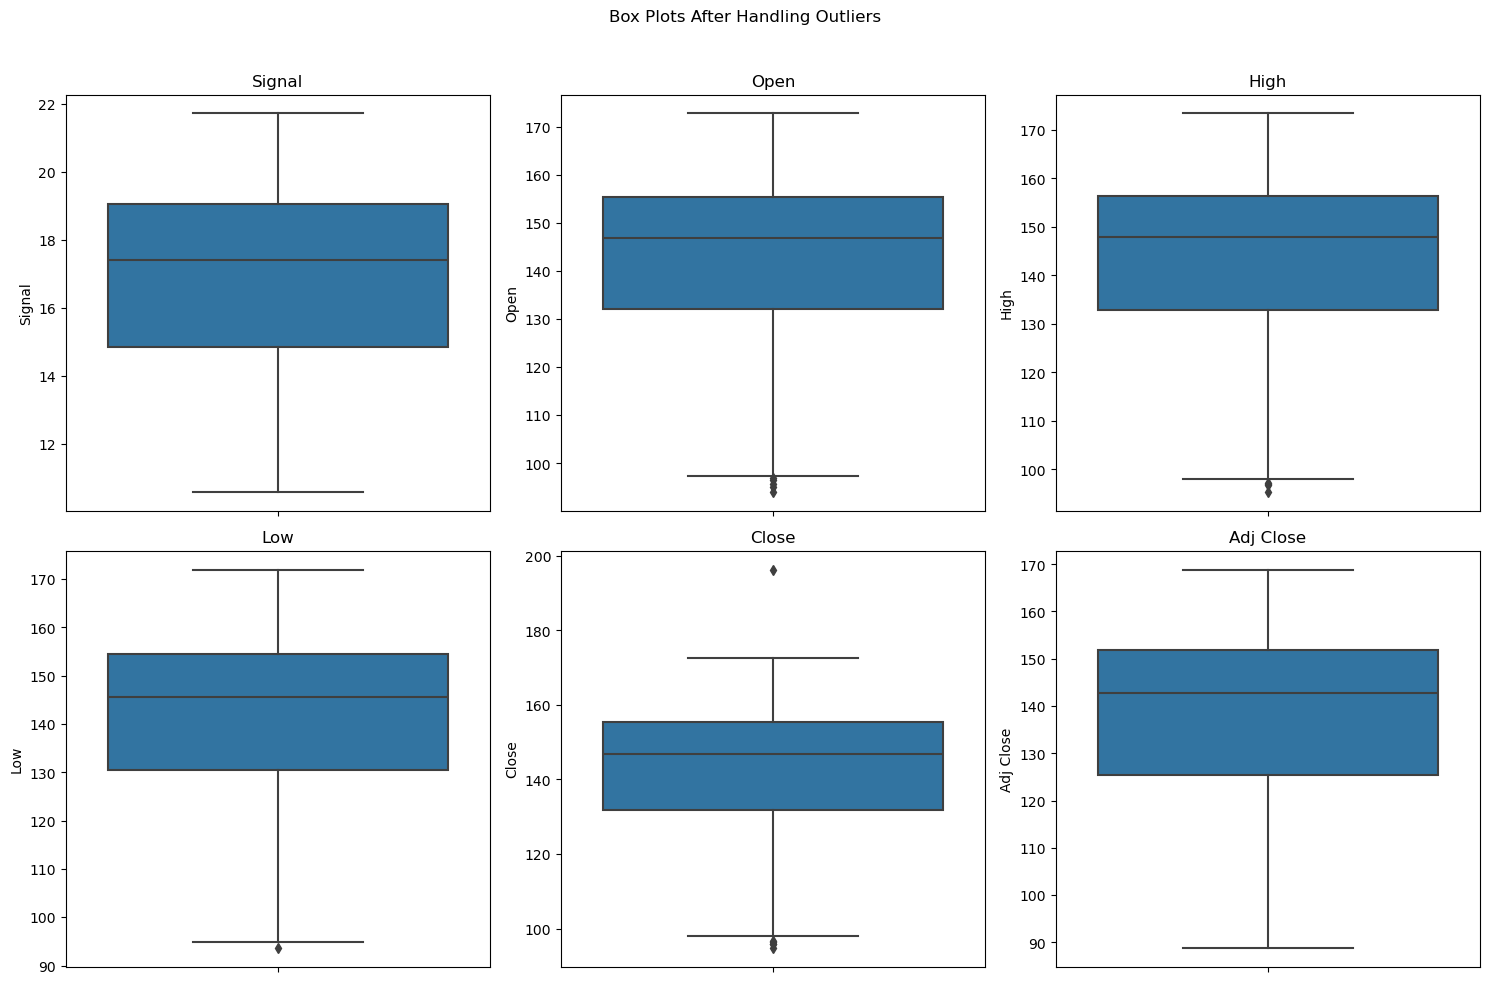

In [13]:
# Plot box plots after handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots After Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

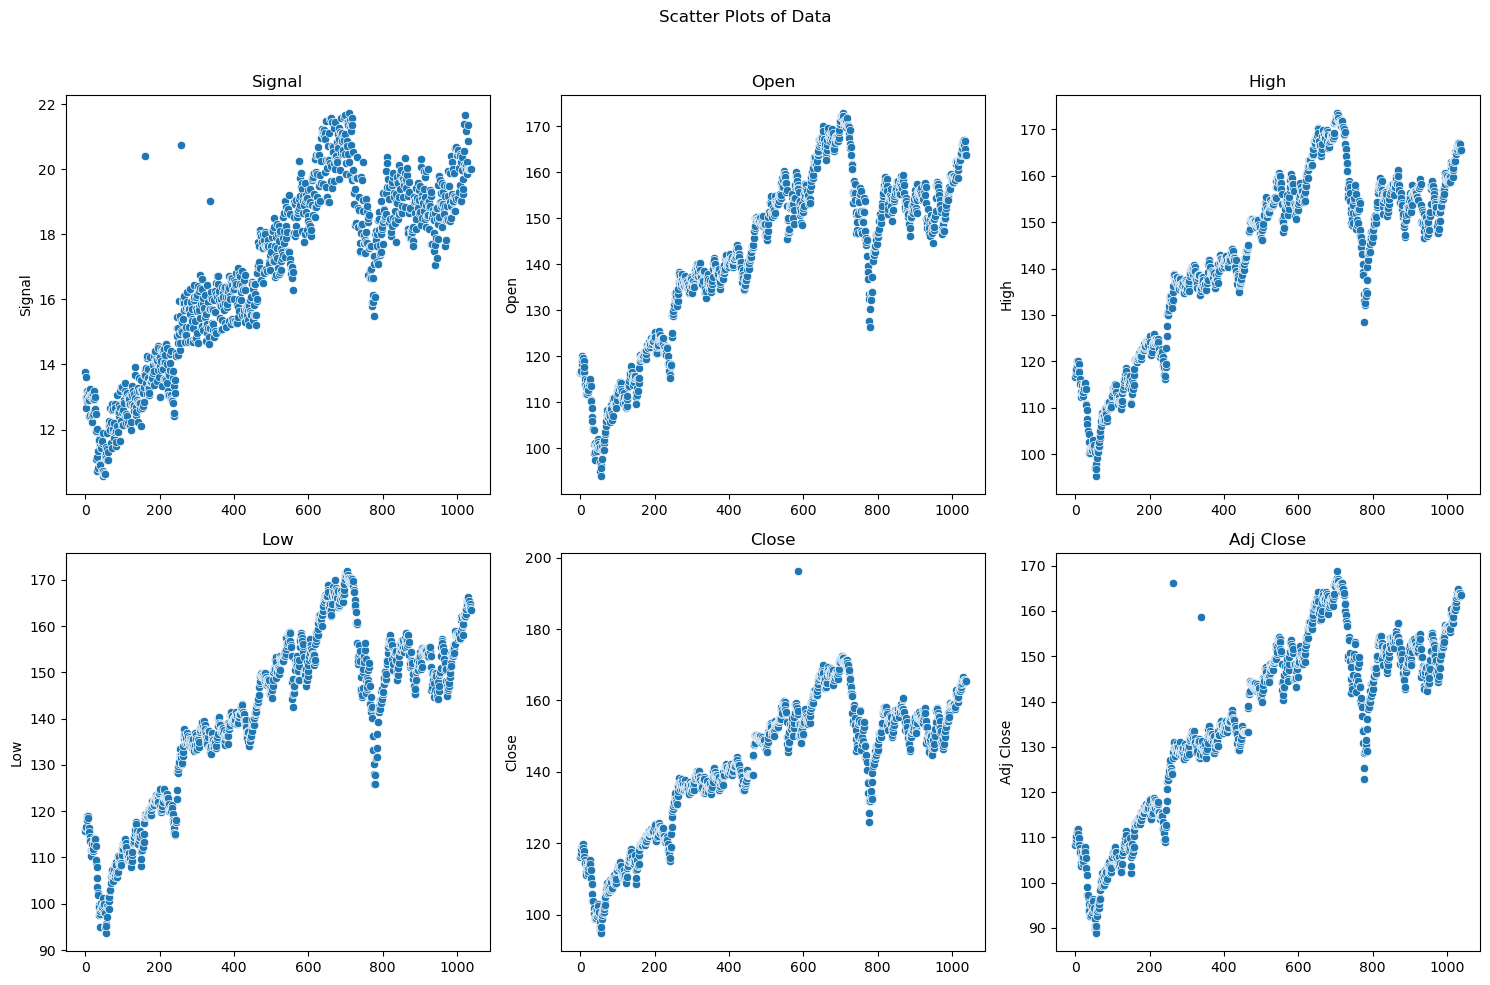

In [14]:
# Plot scatter plots
plt.figure(figsize=(15, 10))
plt.suptitle('Scatter Plots of Data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df.index, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/var/folders/n2/82c6yj0j1bv4wfsy94kcxn_80000gn/T/ipykernel_94760/1774482775.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)


Number of data points with increases more than 10 times the average move in Signal: 1
Number of data points with increases more than 10 times the average move in Open: 0
Number of data points with increases more than 10 times the average move in High: 0
Number of data points with increases more than 10 times the average move in Low: 0
Number of data points with increases more than 10 times the average move in Close: 1
Number of data points with increases more than 10 times the average move in Adj Close: 2


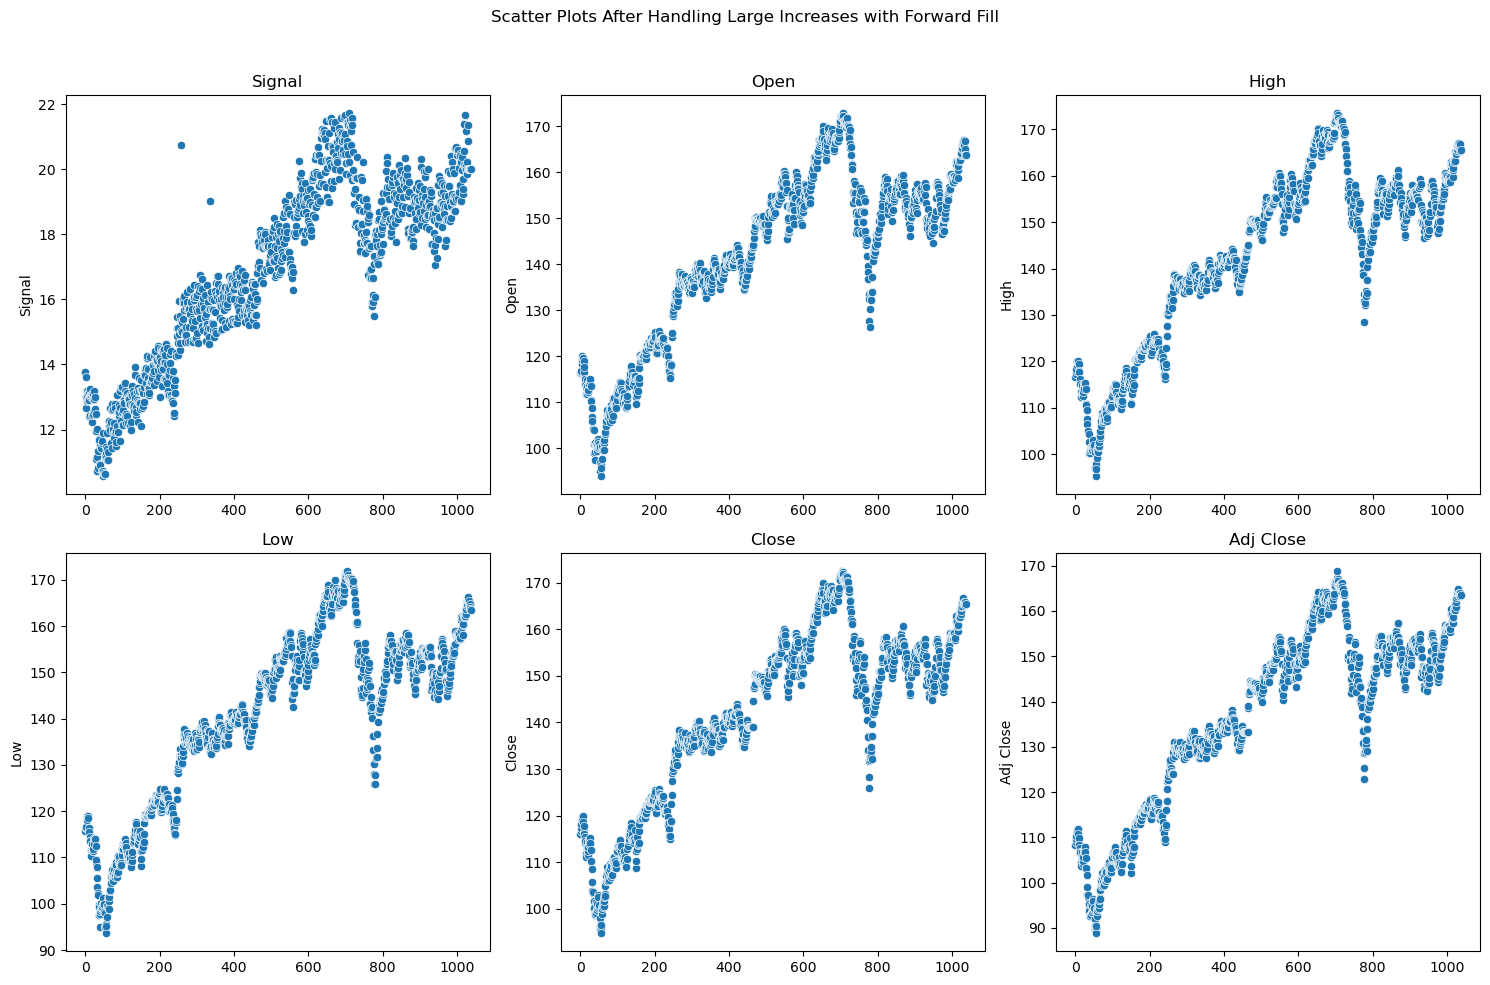

In [15]:
# Function to handle large increases by forward filling
def handle_large_increases_ffill(column, multiplier):
    # Calculate the differences between consecutive data points
    differences = df[column].diff()
    
    # Identify data points with increases more than 10 times the average move
    large_increases = differences > (multiplier * differences.abs().mean())
    
    # Replace data points with large increases with NaN
    df.loc[large_increases, column] = float('nan')
    
    # Forward fill NaN values
    df[column].fillna(method='ffill', inplace=True)
    
    print(f"Number of data points with increases more than {multiplier} times the average move in {column}: {large_increases.sum()}")

# Specify the multiplier for identifying large increases
multiplier = 10  # Adjust this multiplier as needed

# Handle large increases by forward filling for each column
for col in columns_to_check:
    handle_large_increases_ffill(col, multiplier)

# Plot scatter plots after handling large increases
plt.figure(figsize=(15, 10))
plt.suptitle('Scatter Plots After Handling Large Increases with Forward Fill')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df.index, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [16]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
                                Date       Signal         Open         High  \
count                           1038  1038.000000  1038.000000  1038.000000   
mean   2017-12-11 17:03:48.901734144    16.852883   141.847360   142.691801   
min              2015-11-19 00:00:00    10.582996    94.080002    95.400002   
25%              2016-11-30 06:00:00    14.821290   132.132496   132.912495   
50%        

## Part 2

In [17]:
df_cross_corr = df.copy()
df_cross_corr['Date'] = pd.to_datetime(df_cross_corr['Date'])
df_cross_corr = df_cross_corr.set_index('Date').asfreq('D').dropna() 

# To define the range of lags
max_lag = 10
lag_range = np.arange(-max_lag, max_lag + 1)

# To compute the cross-correlation between Signal indicator and each price columns with a corresponding lag 
cross_corr_matrix = []
for columns in df_cross_corr.columns:
    if columns == 'Signal':
        continue    
    cross_corr = []
    for lag in lag_range:
        cross_corr.append(df_cross_corr['Signal'].corr(df_cross_corr[columns].shift(lag)))
    cross_corr_matrix.append(cross_corr)

# To determine the optimal lag that corresponds to the underlying price
for index, cross_corr in enumerate(cross_corr_matrix):
    optimal_lag_index = np.argmax(np.abs(cross_corr))
    optimal_lag = lag_range[optimal_lag_index]
    column_name = df_cross_corr.columns[index + 1]  # Skip the 'Signal' column
    if optimal_lag <= 0:
        print(f'{column_name} indicator is a \033[1mlagging indicator\033[0m ({optimal_lag} days) and is \033[1mineffective\033[0m in forecasting ETF')
    elif optimal_lag > 0:
        print(f'{column_name} indicator is a \033[1mleading indicator\033[0m ({optimal_lag} days) and is \033[1meffective\033[0m in forecasting ETF')

Open indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
High indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Low indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Close indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Adj Close indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF


Actual Open Price vs Predicted Open Price
Mean Squared Error: 23.77
Root Mean Squared Error: 4.87
Mean Absolute Error: 3.88
R-squared: 0.92


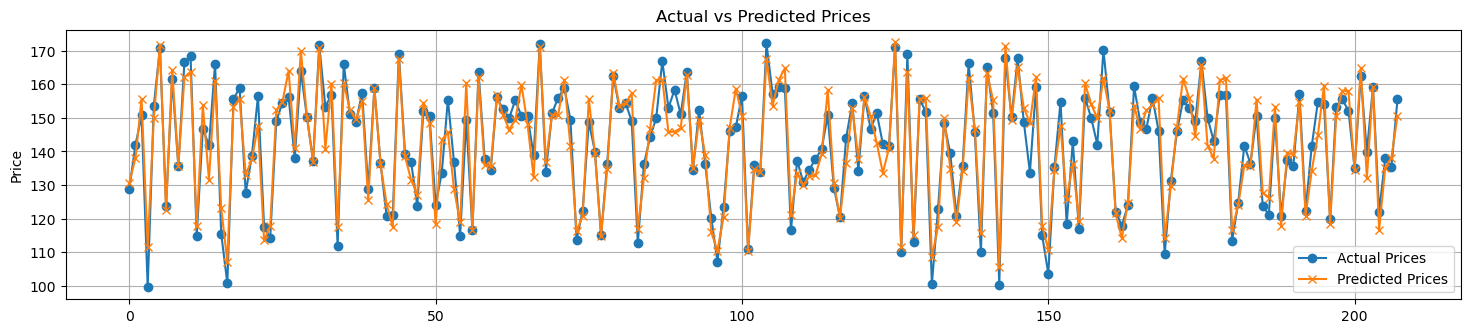

Actual High Price vs Predicted High Price
Mean Squared Error: 22.96
Root Mean Squared Error: 4.79
Mean Absolute Error: 3.82
R-squared: 0.92


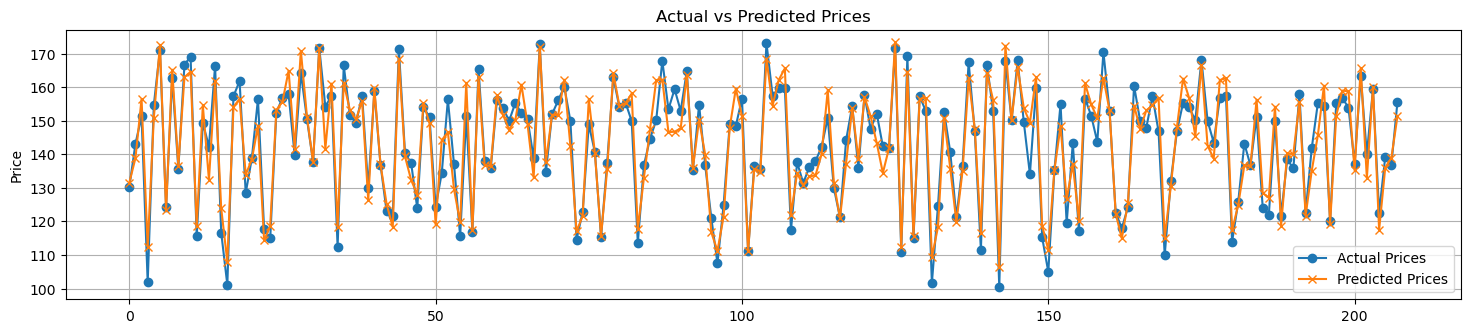

Actual Low Price vs Predicted Low Price
Mean Squared Error: 24.52
Root Mean Squared Error: 4.95
Mean Absolute Error: 3.93
R-squared: 0.92


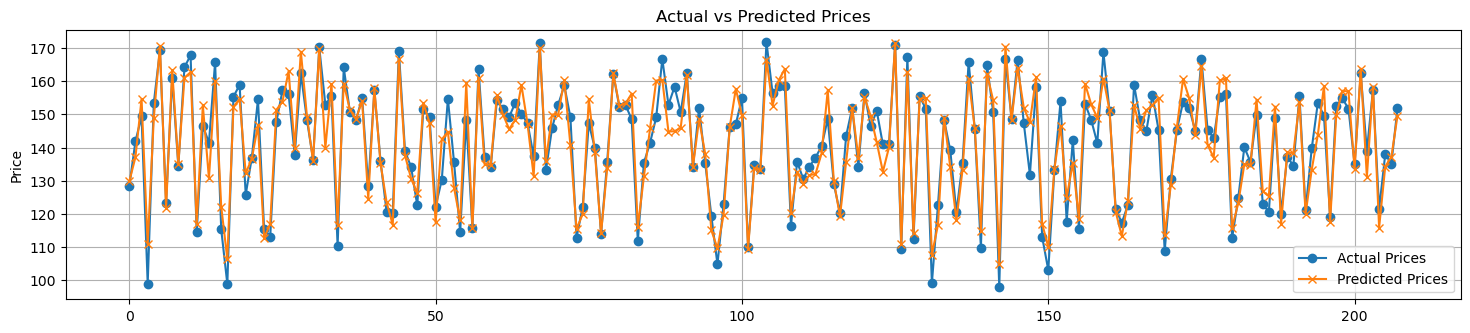

Actual Close Price vs Predicted Close Price
Mean Squared Error: 23.11
Root Mean Squared Error: 4.81
Mean Absolute Error: 3.82
R-squared: 0.92


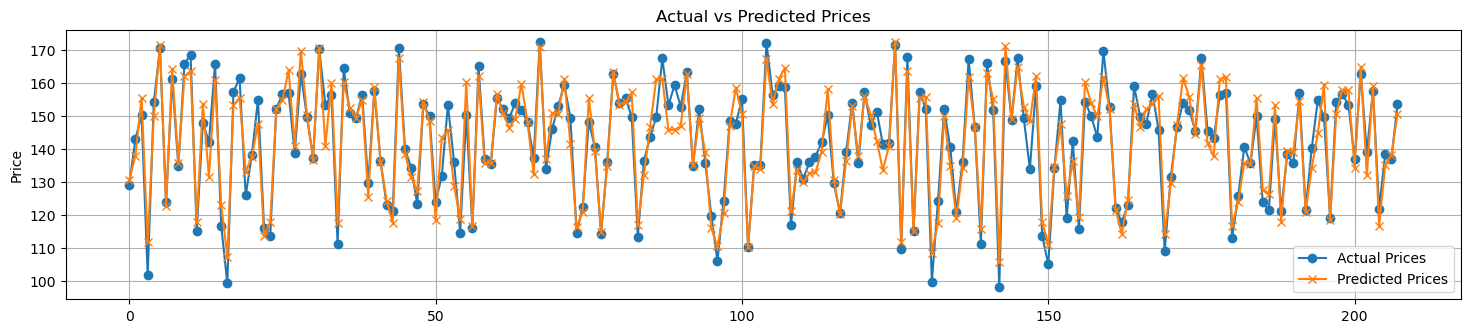

Actual Adj Close Price vs Predicted Adj Close Price
Mean Squared Error: 21.71
Root Mean Squared Error: 4.66
Mean Absolute Error: 3.76
R-squared: 0.94


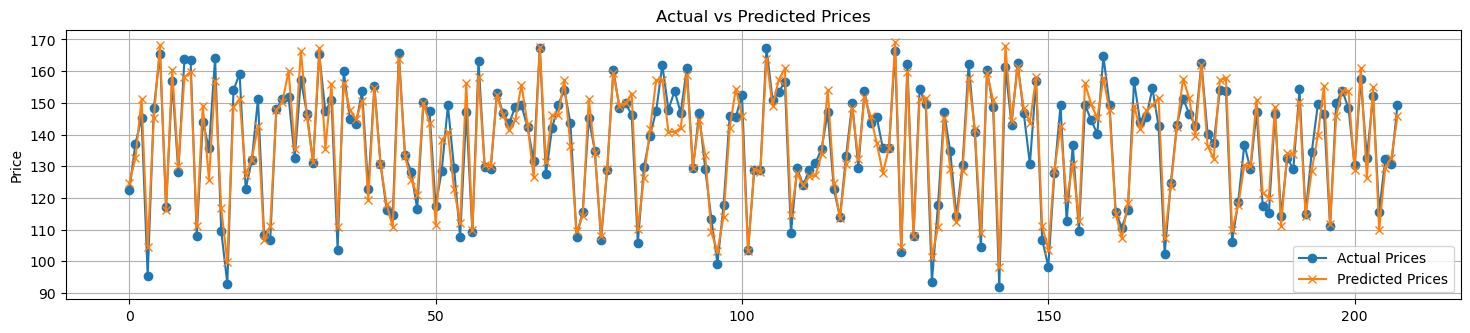

In [18]:
# Linear Regression Analysis, to determine whether the Signal Indicator is a able to predict/forecast clsoing prices

df_linear_reg = df.copy()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for each_column in df_linear_reg.columns[2:]:

    # To define target and feature for the linear regression model
    feature_data = df_linear_reg[['Signal']]
    target_data = df_linear_reg[each_column]

    # To create a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(feature_data, 
                                                        target_data, 
                                                        test_size = 0.2, 
                                                        random_state = 10)

    # To create the linear regression model to price
    model = LinearRegression()
    model.fit(X_train, y_train)

    # To predict the closing price
    y_pred = model.predict(X_test)

    # To determine the Signal's ability to predict the price
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'R-squared: {r2:.2f}')

    # To visualise the performance of the model
    plt.figure(figsize = (18, 3.5))
    plt.plot(y_test.values, 
             label = 'Actual Prices', 
             marker = 'o')
    plt.plot(y_pred, 
             label = 'Predicted Prices', 
             marker = 'x')
    plt.title('Actual vs Predicted Prices')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Actual Open Price vs Predicted Open Price
                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  830
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2624.301
Date:                Sat, 01 Jun 2024   AIC                           5256.601
Time:                        01:39:12   BIC                           5275.487
Sample:                             0   HQIC                          5263.843
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.9509      1.297     26.174      0.000      31.409      36.493
Signal         6.4024      0.075     85.593      0.000       6.256       6.549
ar.L1     

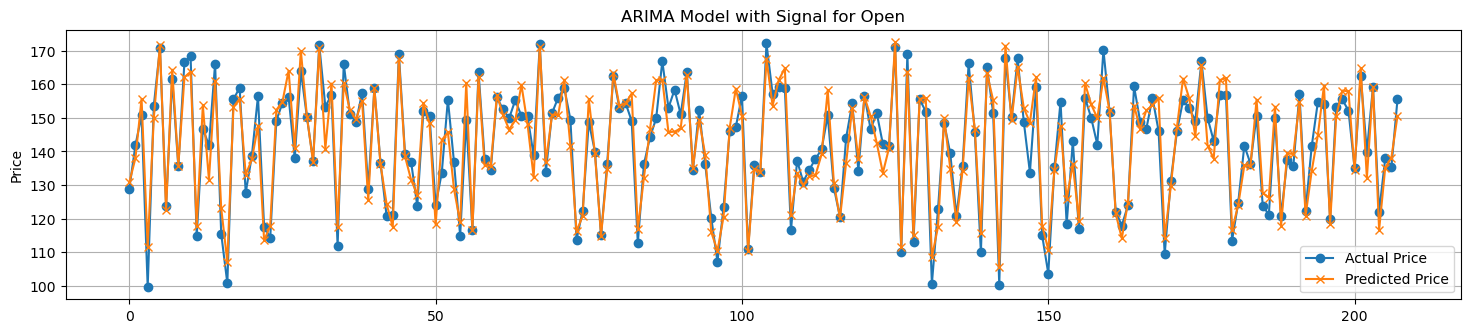

Actual High Price vs Predicted High Price
                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  830
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2604.969
Date:                Sat, 01 Jun 2024   AIC                           5217.938
Time:                        01:39:12   BIC                           5236.823
Sample:                             0   HQIC                          5225.180
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.6465      1.273     27.223      0.000      32.152      37.141
Signal         6.4116      0.073     87.447      0.000       6.268       6.555
ar.L1     

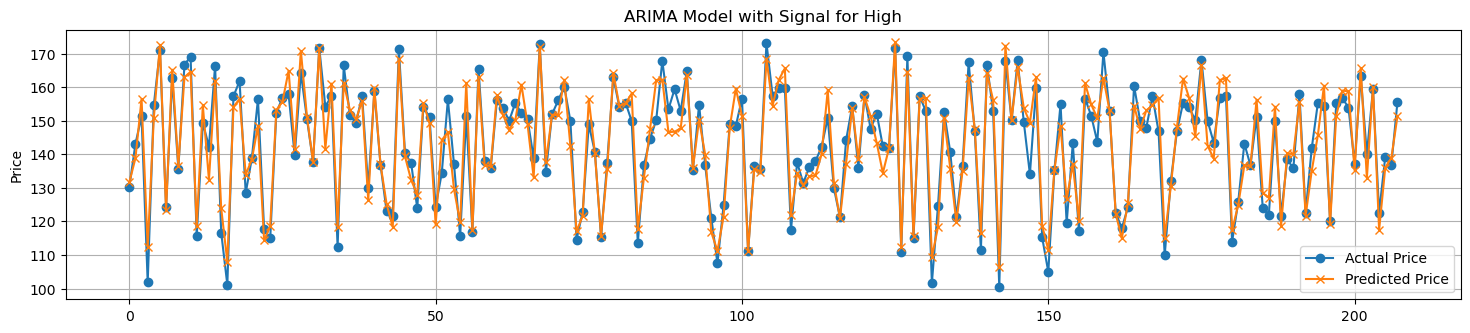

Actual Low Price vs Predicted Low Price
                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                  830
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2622.771
Date:                Sat, 01 Jun 2024   AIC                           5253.542
Time:                        01:39:12   BIC                           5272.428
Sample:                             0   HQIC                          5260.784
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.5141      1.290     25.978      0.000      30.986      36.043
Signal         6.3729      0.074     85.597      0.000       6.227       6.519
ar.L1       

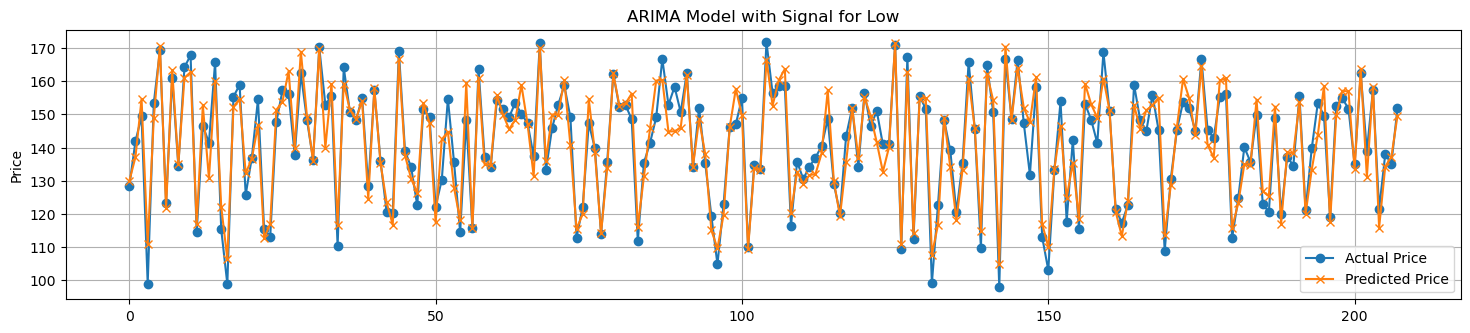

Actual Close Price vs Predicted Close Price
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  830
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2601.243
Date:                Sat, 01 Jun 2024   AIC                           5210.486
Time:                        01:39:12   BIC                           5229.371
Sample:                             0   HQIC                          5217.728
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.0583      1.263     26.973      0.000      31.584      36.533
Signal         6.3939      0.073     87.999      0.000       6.252       6.536
ar.L1   

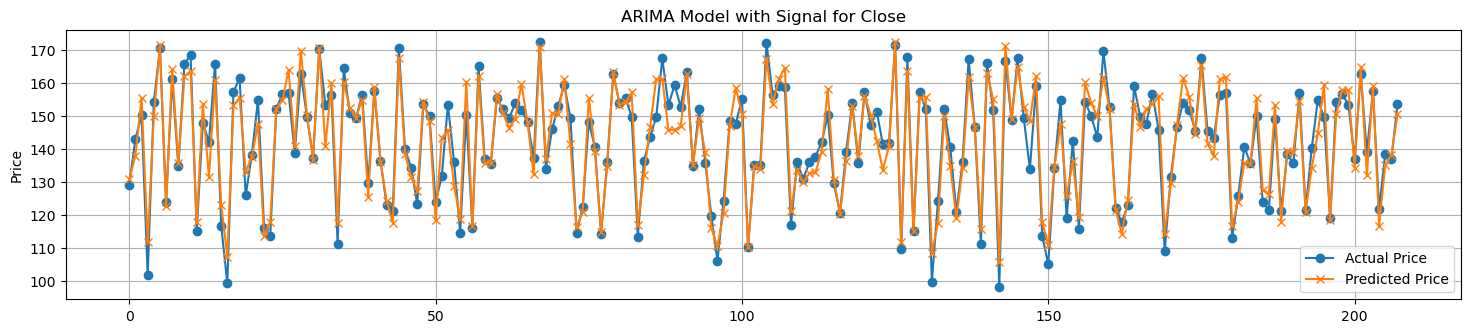

Actual Adj Close Price vs Predicted Adj Close Price
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  830
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2583.420
Date:                Sat, 01 Jun 2024   AIC                           5174.841
Time:                        01:39:12   BIC                           5193.727
Sample:                             0   HQIC                          5182.083
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1826      1.266     17.517      0.000      19.701      24.665
Signal         6.7884      0.073     93.508      0.000       6.646       6.931


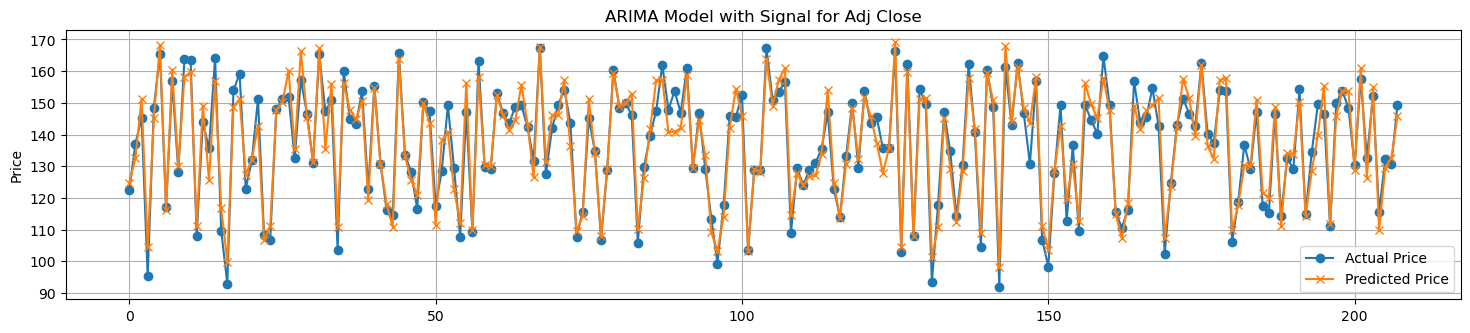

In [21]:
# ARIMA Model, to determine whether the Signal Indicator is a able to predict/forecast clsoing prices

df_arima = df.copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima = df_arima.set_index('Date').asfreq('D').dropna() 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

for each_column in df_arima.columns[1 : ]:

    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')
    
    feature_data = df_arima[['Signal']]
    target_data = df_arima[each_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_data, 
                                                        target_data, 
                                                        test_size=0.2,
                                                        random_state = 10)
    
    # Fit ARIMA model 
    model = ARIMA(y_train, X_train, order=(1, 0, 0))
    arima_fit = model.fit()
    print(arima_fit.summary())
    
    # Predict future prices using the signal
    signal_forecast = arima_fit.forecast(steps = len(X_test), exog = X_test)

    # To determine the Signal's ability to predict the price
    arima_mse = mean_squared_error(y_test, signal_forecast)
    arima_rmse = np.sqrt(arima_mse)
    arima_mae = mean_absolute_error(y_test, signal_forecast)
    arima_r2 = r2_score(y_test, signal_forecast)


    print(f'Mean Squared Error: {arima_mse:.2f}')
    print(f'Root Mean Squared Error: {arima_rmse:.2f}')
    print(f'Mean Absolute Error: {arima_mae:.2f}')
    print(f'R-squared: {arima_r2:.2f}')

    # Plot the actual vs. predicted values
    plt.figure(figsize = (18, 3.5))
    plt.plot(range(len(y_test)), 
             y_test, 
             label = 'Actual Price',
             marker = 'o')
    plt.plot(range(len(y_test)), 
             signal_forecast, 
             label = 'Predicted Price',
             marker = 'x')
    plt.title(f'ARIMA Model with Signal for {each_column}')
    plt.ylabel('Price')
    plt.legend()    
    plt.grid(True)
    plt.show()

Actual Open Price vs Predicted Open Price
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.0037
Test Loss: 0.003566666506230831
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual Open Price vs Predicted Open Price
Mean Squared Error: 22.10
Root Mean Squared Error: 4.70
Mean Absolute Error: 3.63
R-squared: 0.94


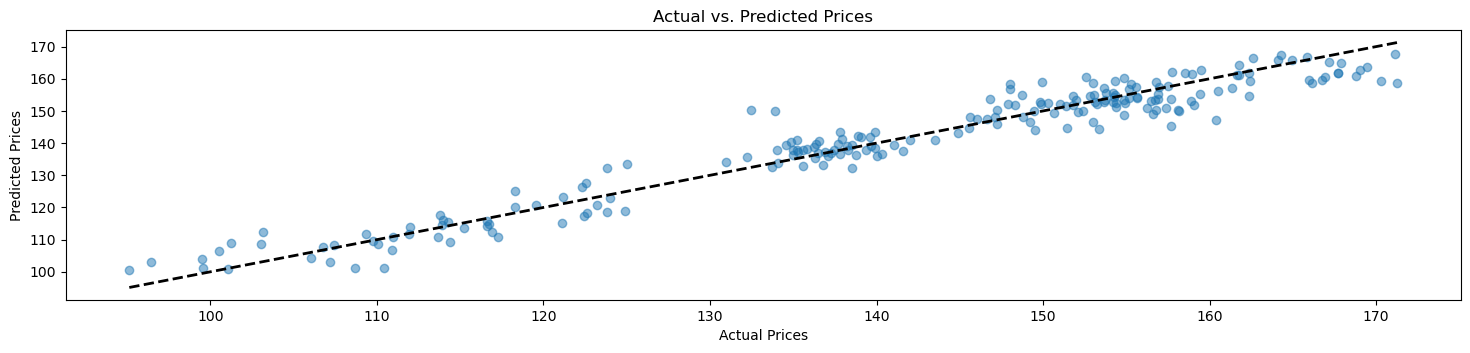

Actual High Price vs Predicted High Price
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0036
Test Loss: 0.0035091787576675415
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual High Price vs Predicted High Price
Mean Squared Error: 21.34
Root Mean Squared Error: 4.62
Mean Absolute Error: 3.49
R-squared: 0.94


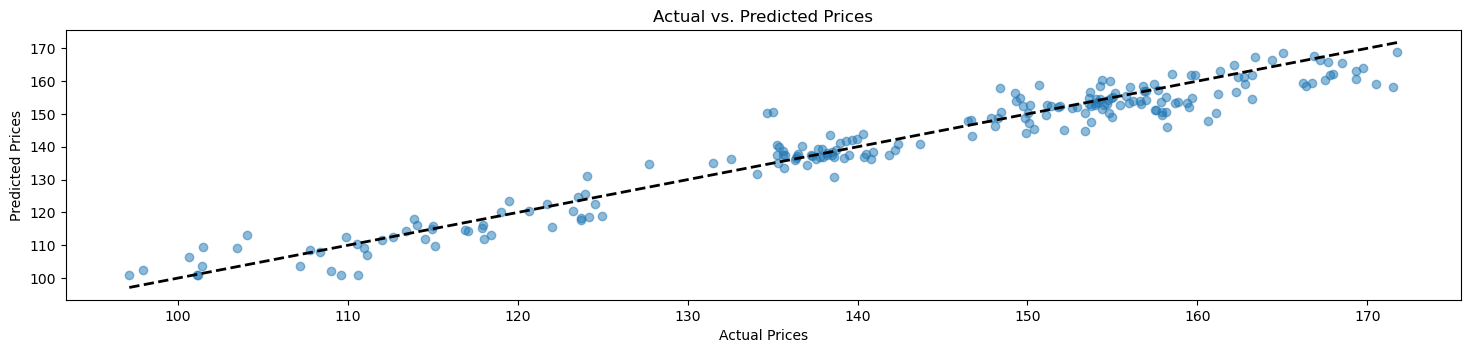

Actual Low Price vs Predicted Low Price
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.0041
Test Loss: 0.004010650794953108
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual Low Price vs Predicted Low Price
Mean Squared Error: 24.60
Root Mean Squared Error: 4.96
Mean Absolute Error: 3.83
R-squared: 0.93


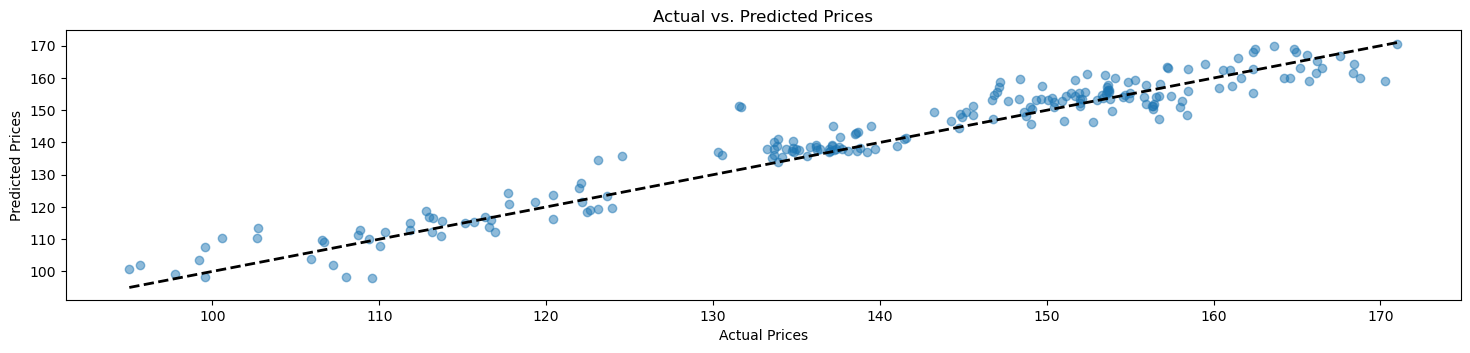

Actual Close Price vs Predicted Close Price
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.0039
Test Loss: 0.003666176227852702
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual Close Price vs Predicted Close Price
Mean Squared Error: 22.14
Root Mean Squared Error: 4.71
Mean Absolute Error: 3.54
R-squared: 0.94


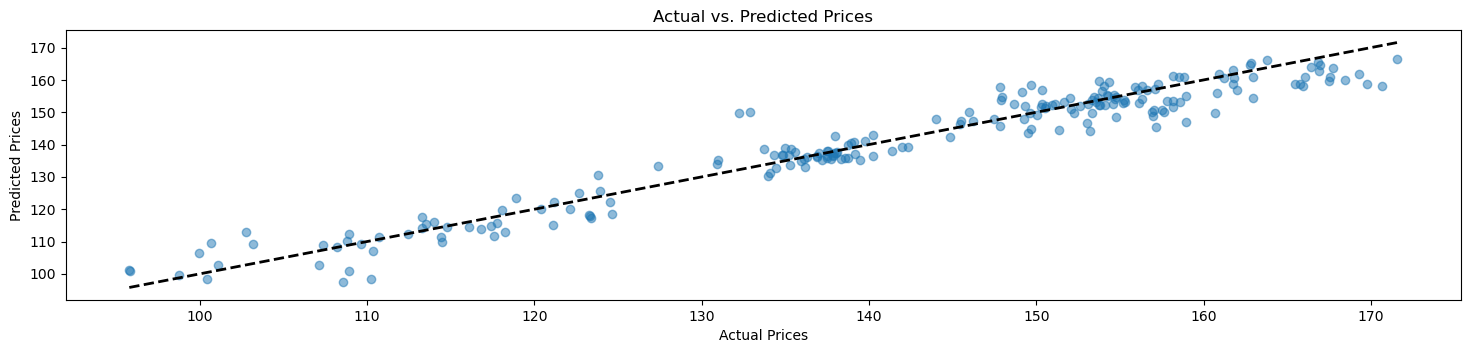

Actual Adj Close Price vs Predicted Adj Close Price
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0037
Test Loss: 0.0035711252130568027
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual Adj Close Price vs Predicted Adj Close Price
Mean Squared Error: 22.87
Root Mean Squared Error: 4.78
Mean Absolute Error: 3.69
R-squared: 0.94


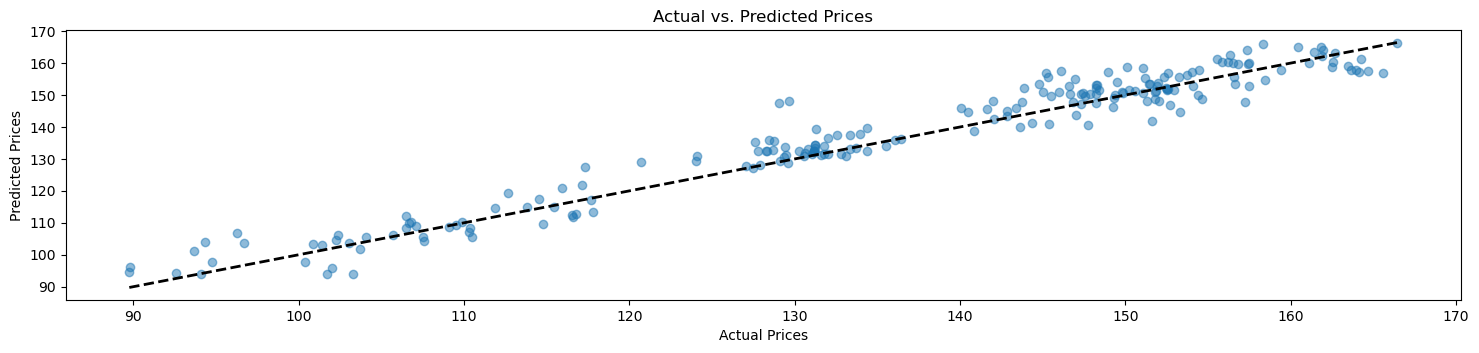

In [37]:
df_nn = df.copy()
df_nn['Date'] = pd.to_datetime(df_nn['Date'])
df_nn = df_nn.set_index('Date').asfreq('D').dropna()

# Iterate over each column (except 'Date')
for each_column in df_nn.columns[1 : ]:
    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')

    # Extract feature and target data
    feature_data = df_nn['Signal'].values.reshape(-1, 1) 
    target_data = df_nn[each_column].values.reshape(-1, 1) 

    # To normalize the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(feature_data)
    y_scaled = scaler_y.fit_transform(target_data)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                        test_size = 0.2, random_state = 42)

    # To define the neural network architecture
    model = Sequential([
        Dense(64, activation = 'relu', input_shape = (1, )),
        Dense(64, activation = 'relu'),
        Dense(1)
    ])

    # To compile the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # To train the model
    history = model.fit(X_train, y_train, epochs = 1000, batch_size = 32, 
                        validation_split = 0.2, verbose = 0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print('Test Loss:', loss)

    # Predicting the price
    predictions = model.predict(X_test)
    predictions_inv = scaler_y.inverse_transform(predictions)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # To determine the Signal's ability to predict the price
    nn_mse = mean_squared_error(y_test_inv, predictions_inv)
    nn_rmse = np.sqrt(nn_mse)
    nn_mae = mean_absolute_error(y_test_inv, predictions_inv)
    nn_r2 = r2_score(y_test_inv, predictions_inv)

    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')
    print(f'Mean Squared Error: {nn_mse:.2f}')
    print(f'Root Mean Squared Error: {nn_rmse:.2f}')
    print(f'Mean Absolute Error: {nn_mae:.2f}')
    print(f'R-squared: {nn_r2:.2f}')

    # Plot actual vs. predicted prices
    plt.figure(figsize=(18, 3.5))
    plt.scatter(y_test_inv, predictions_inv, alpha = 0.5)
    plt.plot([y_test_inv.min(), y_test_inv.max()], 
             [y_test_inv.min(), y_test_inv.max()], 
             'k--', lw = 2)
    plt.title('Actual vs. Predicted Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.show()